In [ ]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
from sklearn import linear_model
import scipy
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def readJson(path):
  data = pd.read_json(path,
                      lines=True,
                      compression='gzip')
  return data

In [ ]:
data = readJson("renttherunway_final_data.json.gz")

In [ ]:
###########################################################
###.                 Clean up the data                 .###
###########################################################

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [ ]:
print(data.head(5))

   fit  user_id bust size  item_id  weight  rating     rented for  \
0  fit   420272       34d  2260466  137lbs    10.0       vacation   
1  fit   273551       34b   153475  132lbs    10.0          other   
2  fit   360448       NaN  1063761     NaN    10.0          party   
3  fit   909926       34c   126335  135lbs     8.0  formal affair   
4  fit   151944       34b   616682  145lbs    10.0        wedding   

                                         review_text          body type  \
0  An adorable romper! Belt and zipper were a lit...          hourglass   
1  I rented this dress for a photo shoot. The the...  straight & narrow   
2  This hugged in all the right places! It was a ...                NaN   
3  I rented this for my company's black tie award...               pear   
4  I have always been petite in my upper body and...           athletic   

                                      review_summary category height  size  \
0                               So many compliments!   r

In [ ]:
# Remove NaNs 
print(data.shape)
weight_na = data.isna().sum()['weight']
height_na = data.isna().sum()['height']
data.isna().sum()

(192544, 15)


fit                   0
user_id               0
bust size         18411
item_id               0
weight            29982
rating               82
rented for           10
review_text           0
body type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

In [ ]:
data1 = data.dropna()
print(data1.shape)
# dropping too many entries 
# so fixing weight and height NaNs with average values of respective entries 

(146381, 15)


In [ ]:
# Convert weight to float and replace NaNs
data['weight'] = data['weight'].fillna("0lbs")

convertweight = lambda x: float(str(x).split("lbs")[0])
data['weight'] = data['weight'].apply(convertweight)
avg_weight = data['weight'].sum() / (data.shape[0] - weight_na)

replaceweight = lambda x: avg_weight if (x==0) else x
data['weight'] = data['weight'].apply(replaceweight)

print(data.dtypes['weight'])
data.isna().sum()['weight']

float64


0

In [ ]:
# Convert height to inches and replace NaNs
data['height'] = data['height'].fillna("0' 0'")

convertheight = lambda x: int(x.split(' ')[0][:-1])*12 + int(x.split(' ')[1][:-1])
data['height'] = data['height'].apply(convertheight)
avg_height = data['height'].sum() / (data.shape[0] - height_na)

replaceheight = lambda x: avg_weight if (x==0) else x
data['height'] = data['height'].apply(replaceheight)

print(data.dtypes['height'])
data.isna().sum()['height']

float64


0

In [ ]:
# Convert date to nice format 
data['review_date'] = data['review_date'].astype('datetime64')
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month


In [ ]:
#Adjectives data generation 
adjective_count = lambda x: len([token for token, pos in nltk.pos_tag(nltk.word_tokenize(x)) if pos.startswith('JJ')])
data["adjectives"] = data["review_text"].apply(adjective_count)


In [ ]:
review_length = lambda x: len(x)
review_words = lambda x: len(x.split(' '))
count_ex = lambda x: x.count('!')
data["review_length"] = data["review_text"].apply(review_length)
data["review_words"] = data["review_text"].apply(review_words)
data["review_ex"] = data["review_text"].apply(count_ex)

In [ ]:
data = data.dropna()
data.shape

(165128, 15)

mean =  137.231748573412
std =  20.306233294767612


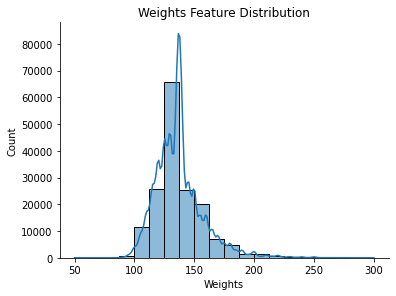

In [ ]:
#Analyse weights data 
fig = sns.displot(data, kde=True, bins = 20, x="weight", height=4, aspect=1.4).set(title ="Weights Feature Distribution")
fig.set_axis_labels("Weights", "Count")
fig.savefig("weights_statistics.png")
print("mean = ", np.mean(data["weight"]))
print("std = ", np.std(data["weight"]))

mean =  65.48991036529364
std =  4.585711685044434


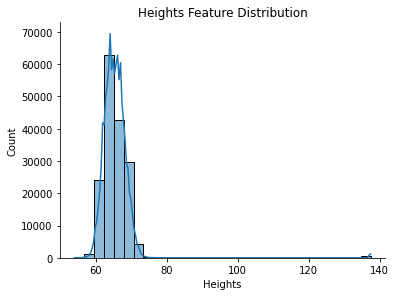

In [ ]:
#Analyse Height data 
fig = sns.displot(data, kde=True, bins = 30, x="height", height=4, aspect=1.4).set(title ="Heights Feature Distribution")
fig.set_axis_labels("Heights", "Count")
fig.savefig("heights_statistics.png")
print("mean = ", np.mean(data["height"]))
print("std = ", np.std(data["height"]))

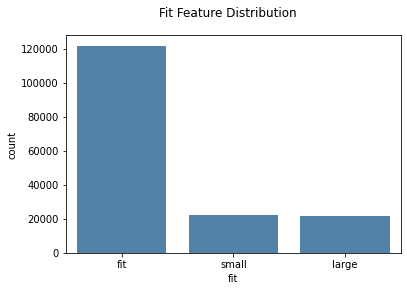

In [ ]:
#Analyze Fit data 
fig = sns.countplot(data["fit"], color='steelblue').get_figure()
fig.suptitle("Fit Feature Distribution")
fig.savefig("fit_statistics.png")
# Fit has more labels. Small and Large labels have very less number of samples (~20k each)
# Can we generate small and large labelled data by randomly selecting fit samples and increase or decrease the size ?

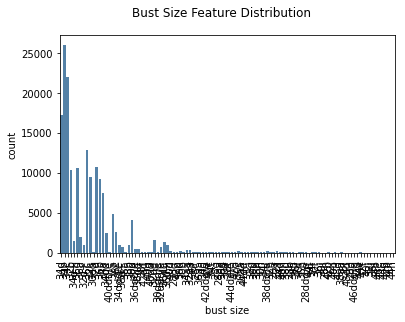

In [ ]:
#Analyze bust size data 
fig = sns.countplot(data["bust size"], color='steelblue', )
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.get_figure()
fig.suptitle("Bust Size Feature Distribution")
fig.savefig("bust_size_statistics.png")
# So many bust sizes. Can we group them ?

mean =  9.080882709171068
std =  1.43792585007179


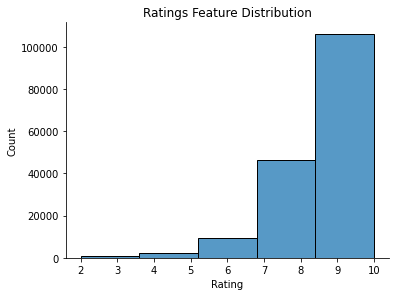

In [ ]:
#Analyze rating data 
fig = sns.displot(data, kde=False, bins = 5, x="rating", height=4, aspect=1.4).set(title ="Ratings Feature Distribution")
fig.set_axis_labels("Rating", "Count")
fig.savefig("rating_statistics.png")
print("mean = ", np.mean(data["rating"]))
print("std = ", np.std(data["rating"]))
# ratings are just 2/4/6/8/10 
# we can convert them to a range from 1-5 

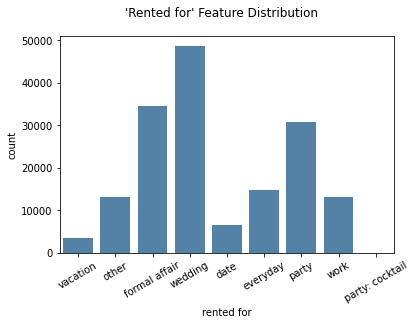

In [ ]:
#Analyze reason for renting data 
fig = sns.countplot(data["rented for"], color='steelblue')
fig.set_xticklabels(fig.get_xticklabels(), rotation=30)
fig = fig.get_figure()
fig.suptitle("'Rented for' Feature Distribution")
fig.savefig("rented_for_statistics.png")
# No party related labels 
# can we remove this label altogether ?

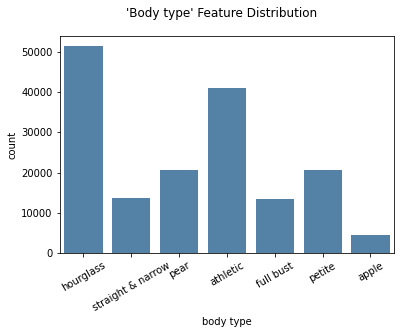

In [ ]:
#Analyze body type data 
fig = sns.countplot(data["body type"], color='steelblue')
fig.set_xticklabels(fig.get_xticklabels(), rotation=30)
fig = fig.get_figure()
fig.suptitle("'Body type' Feature Distribution")
fig.savefig("body_type_statistics.png")

mean =  12.035100043602538
std =  8.218104844018843


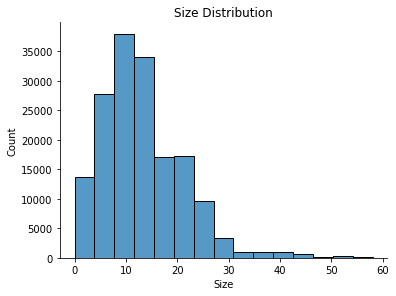

In [ ]:
#Analyze size data
fig = sns.displot(data, kde=False, bins = 15, x="size", height=4, aspect=1.4).set(title ="Size Distribution")
fig.set_axis_labels("Size", "Count")
fig.savefig("size_statistics.png")
print("mean = ", np.mean(data["size"]))
print("std = ", np.std(data["size"]))

mean =  33.96364638341166
std =  8.048610236901316


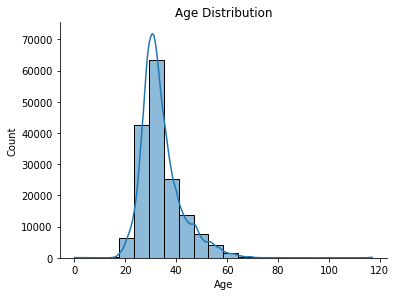

In [ ]:
#Analyze age data
fig = sns.displot(data, kde=True, bins = 20, x="age", height=4, aspect=1.4).set(title ="Age Distribution")
fig.set_axis_labels("Age", "Count")
fig.savefig("age_statistics.png")
print("mean = ", np.mean(data["age"]))
print("std = ", np.std(data["age"]))

dress           79673
gown            37783
sheath          16506
shift            4631
jumpsuit         4445
                ...  
sweatershirt        3
overcoat            2
sweatpants          2
crewneck            1
buttondown          1
Name: category, Length: 68, dtype: int64

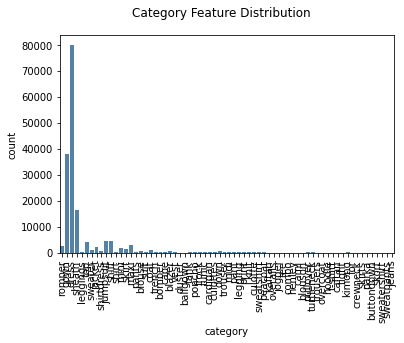

In [ ]:
#Analyze category data 
fig = sns.countplot(data["category"], color='steelblue', )
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.get_figure()
fig.suptitle("Category Feature Distribution")
fig.savefig("category_statistics.png")
data["category"].value_counts()

10    17626
5     16336
6     15872
11    15619
4     14797
12    14483
9     13862
8     12284
3     11818
7     11469
1     11315
2      9647
Name: review_month, dtype: int64

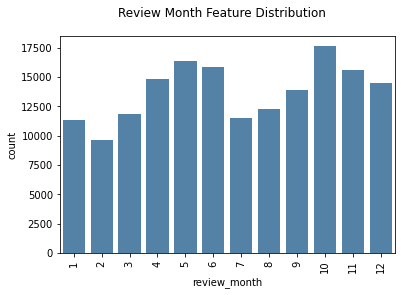

In [ ]:
#Analyze review month data 
fig = sns.countplot(data["review_month"], color='steelblue', )
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.get_figure()
fig.suptitle("Review Month Feature Distribution")
fig.savefig("review_month_statistics.png")
data["review_month"].value_counts()

2017    57116
2016    42224
2015    26926
2014    25800
2013     8852
2012     2979
2018     1057
2011      173
2010        1
Name: review_year, dtype: int64

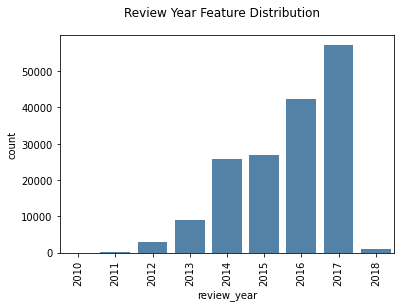

In [ ]:
#Analyze review year data 
fig = sns.countplot(data["review_year"], color='steelblue', )
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.get_figure()
fig.suptitle("Review Year Feature Distribution")
fig.savefig("review_year_statistics.png")
data["review_year"].value_counts()

mean =  6.141005765224553
std =  4.399828464271038


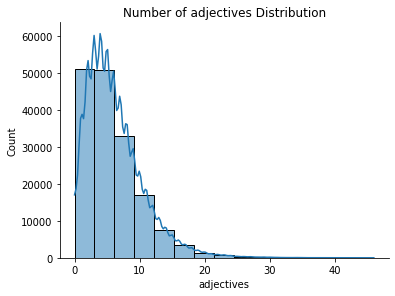

In [ ]:
#Analyze adjective count data
fig = sns.displot(data, kde=True, bins = 15, x="adjectives", height=4, aspect=1.4).set(title ="Number of adjectives Distribution")
fig.set_axis_labels("adjectives", "Count")
fig.savefig("adjectives_statistics.png")
print("mean = ", np.mean(data["adjectives"]))
print("std = ", np.std(data["adjectives"]))

mean =  306.49921878784943
std =  222.3484401728821


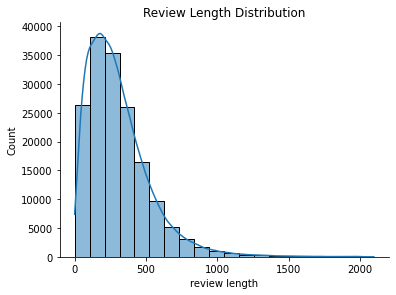

In [ ]:
#Analyze review length data
fig = sns.displot(data, kde=True, bins = 20, x="review_length", height=4, aspect=1.4).set(title ="Review Length Distribution")
fig.set_axis_labels("review length", "Count")
fig.savefig("review_length_statistics.png")
print("mean = ", np.mean(data["review_length"]))
print("std = ", np.std(data["review_length"]))

mean =  60.71776440094957
std =  43.92174625856025


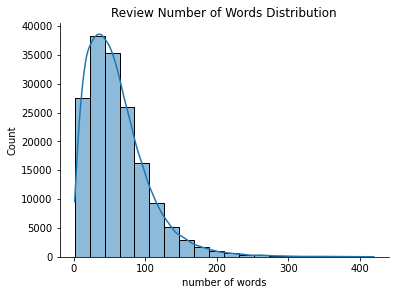

In [ ]:
#Analyze review words length data
fig = sns.displot(data, kde=True, bins = 20, x="review_words", height=4, aspect=1.4).set(title ="Review Number of Words Distribution")
fig.set_axis_labels("number of words", "Count")
fig.savefig("review_words_statistics.png")
print("mean = ", np.mean(data["review_words"]))
print("std = ", np.std(data["review_words"]))

In [ ]:
# The review length and number of words distribution looks similar with similar mean and std params (when scaled down)
# Explore and see if we can eliminate one of the params.

mean =  0.8938823215929461
std =  1.2736296663540234


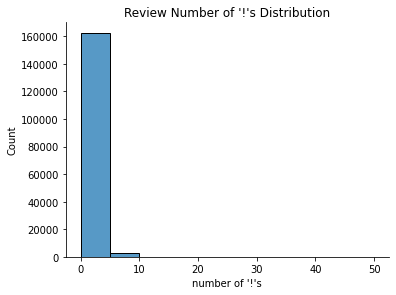

In [ ]:
#Analyze number of exclaimations data
fig = sns.displot(data, kde=False, bins = 10, x="review_ex", height=4, aspect=1.4).set(title ="Review Number of '!'s Distribution")
fig.set_axis_labels("number of '!'s", "Count")
fig.savefig("review_ex_statistics.png")
print("mean = ", np.mean(data["review_ex"]))
print("std = ", np.std(data["review_ex"]))
# does not seem like a good factor or distribution to consider 

In [ ]:
# Save the generated data frame with all the features to a pickle file 
data.to_pickle("./../renttherunway_data_processed.pkl")